# Aim: To simulate for 10 assets on the local by increasing the no of alphas , changing different classical optimisers namely COBYLA ,CG POWELL and trying to run it on qasm simulator, fake backends i.e. Fake Mumbai, Fake Torronto

In [107]:
from qiskit.algorithms.optimizers import COBYLA,CG,POWELL, GradientDescent
from qiskit.algorithms import NumPyMinimumEigensolver, VQE,QAOA
from qiskit.opflow import PauliExpectation, CVaRExpectation
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import LinearEqualityToPenalty
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.translators import from_docplex_mp
from qiskit import execute, Aer
from qiskit.utils import algorithm_globals

import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

In [7]:
#maruti,ongc,tatasteel,hindalco,icici
mu5 = np.array([-0.01278393459,-0.01757157357,0.00153724791,-0.015034464,-0.015034464])#maruti,ongc,tatasteel,hindalco,icici

#maruti,ongc,tatasteel,hindalco,icici,britannia,ultra,wipro
mu8 = np.array([-0.01278393459,-0.01757157357,0.00153724791,-0.015034464,-0.015034464,-0.01387133952,-0.01447346195,
                -0.01674339724])

#maruti,ongc,tatasteel,hindalco,icici,britannia,ultra,wipro,apollo,jublfoods
mu10 = np.array([-0.01278393459,-0.01757157357,0.00153724791,-0.015034464,-0.015034464,-0.01387133952,-0.01447346195,
                -0.01674339724,-0.0132387857,-0.01195091376])

sigma5 = np.array(
    [
        [0.0157149876, 0.01543639416,0.01557457106, 0.01548754824, 0.01551981118],
        [0.01543639416,0.01626383626, 0.01518401219, 0.01572622731, 0.01547586679],
        [0.01557457106, 0.01518401219, 0.03221621237,0.01521450154, 0.01560453568],
        [0.01548754824, 0.01572622731,0.01521450154, 0.01609035237, 0.01563323403],
        [0.01551981118, 0.01547586679,0.01560453568, 0.01563323403, 0.0156661810]
        
    ]
)


sigma8 =  np.array(
    [
        [0.0157149876, 0.01543639416,0.01557457106, 0.01548754824, 0.01551981118,0.01552742087,0.01551068247,0.01549833146],
        [0.01543639416,0.01626383626, 0.01518401219, 0.01572622731, 0.01547586679, 0.01523653022,0.01540274745,0.01539792764],
        [0.01557457106, 0.01518401219, 0.03221621237,0.01521450154, 0.01560453568, 0.01568907088,0.01536051938,0.01517390478],
        [0.01548754824, 0.01572622731,0.01521450154, 0.01609035237, 0.01563323403, 0.01546962982,0.01556278296,0.01563908817],
        [0.01551981118, 0.01547586679,0.01560453568, 0.01563323403, 0.01566618101, 0.01551780546,0.01554861694,0.01554772412],
        [0.01552742087,0.01523653022, 0.01568907088, 0.01546962982, 0.01551780546,0.0156690731,0.01550048831,0.01547100286],
        [0.01551068247,0.01540274745,0.01536051938,0.01556278296,0.01554861694,0.01550048831,0.01570878379,0.01551585945],
        [0.01549833146,0.01539792764,0.01517390478,0.01563908817,0.01554772412,0.01547100286,0.01551585945,0.01568793576]
    ]
)

sigma10 = np.array(
    [
        [0.0157149876, 0.01543639416,0.01557457106, 0.01548754824, 0.01551981118,0.01552742087,0.01551068247,0.01549833146,0.01555422578,0.01560541445],
        [0.01543639416,0.01626383626, 0.01518401219, 0.01572622731, 0.01547586679, 0.01523653022,0.01540274745,0.01539792764,0.01529484431,0.01522477939],
        [0.01557457106, 0.01518401219, 0.03221621237,0.01521450154, 0.01560453568, 0.01568907088,0.01536051938,0.01517390478,0.01544208176,0.01533647982],
        [0.01548754824, 0.01572622731,0.01521450154, 0.01609035237, 0.01563323403, 0.01546962982,0.01556278296,0.01563908817,0.01556359729,0.01560570359],
        [0.01551981118, 0.01547586679,0.01560453568, 0.01563323403, 0.01566618101, 0.01551780546,0.01554861694,0.01554772412,0.01554744909,0.01561664097],
        [0.01552742087,0.01523653022, 0.01568907088, 0.01546962982, 0.01551780546, 0.0156690731,0.01550048831,0.01547100286,0.01552910437,0.0155765202],
        [0.01551068247,0.01540274745,0.01536051938,0.01556278296,0.01554861694,0.01550048831,0.01570878379,0.01551585945,0.01551281895,0.01563468601],
        [0.01549833146,0.01539792764,0.01517390478,0.01563908817,0.01554772412,0.01547100286,0.01551585945,0.01568793576,0.0155514752,0.01569287103],
        [0.01555422578,0.01529484431,0.01544208176,0.01556359729,0.01554744909,0.01552910437,0.01551281895,0.0155514752,0.0157783728,0.01565209048],
        [0.01560541445,0.01522477939,0.01533647982,0.01560570359,0.01561664097,0.0155765202,0.01563468601,0.01569287103,0.01565209048,0.0161425637]
    ]
)


In [8]:
# prepare problem instance
n = 10  # number of assets
q = 0.5  # risk factor
budget = n // 2  # budget
penalty = 2 * n  # scaling of penalty term

In [9]:
# create docplex model
mdl = Model("portfolio_optimization")
x = mdl.binary_var_list(range(n), name="x")
objective = mdl.sum([mu10[i] * x[i] for i in range(n)])
objective -= q * mdl.sum([sigma10[i, j] * x[i] * x[j] for i in range(n) for j in range(n)])
mdl.maximize(objective)
mdl.add_constraint(mdl.sum(x[i] for i in range(n)) == budget)

# case to
qp = from_docplex_mp(mdl)

Solving the problem classically

In [10]:
%%time
opt_result = MinimumEigenOptimizer(NumPyMinimumEigensolver()).solve(qp)
print(opt_result.prettyprint())

objective function value: -0.253555310115
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS
CPU times: total: 172 ms
Wall time: 220 ms


Using a linear equality to penalty converter on the quadratic problem so that the constraints are taken into account in the objective, making the problem simpler. Converting to an ising model after that

In [11]:
# we convert the problem to an unconstrained problem for further analysis,
# otherwise this would not be necessary as the MinimumEigenSolver would do this
# translation automatically
linear2penalty = LinearEqualityToPenalty(penalty=penalty)
qp = linear2penalty.convert(qp)
_, offset = qp.to_ising()

1-Using cobyla optimizer and qasm simulator. We are using CVaR expectation and hence, created a list of alpha values

In [12]:
# set classical optimizer
maxiter = 100
optimizer = COBYLA(maxiter=maxiter)

# set variational ansatz
#ansatz = RealAmplitudes(n, reps=1)
#m = ansatz.num_parameters

# set backend
backend_name = "qasm_simulator"  # use this for QASM simulator
# backend_name = 'aer_simulator_statevector'  # use this for statevector simlator
backend = Aer.get_backend(backend_name)

# run variational optimization for different values of alpha
alphas = [1.0, 0.50, 0.25,0.30,0.40,0.45]  # confidence levels to be evaluated

Fitting CVaR QAOA

In [13]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=backend,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.25355531011501853
variable values: x_0=1.

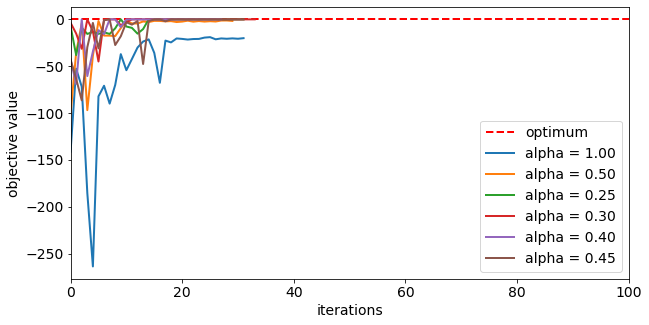

In [15]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [16]:
qaoa.ansatz.count_ops()

OrderedDict([('h', 10), ('PauliEvolution', 2)])

In [17]:
from qiskit import transpile

In [18]:
qc_basis = transpile(qaoa.ansatz, backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

In [19]:
gate_dict

OrderedDict([('cx', 90), ('u', 75)])

Finding the circuit cost

#Cost is described as following in the into notebook for a maxcut problem 
#task_price = 0.25 # price for submitting task to system (in dollars) 

#price_per_CNOT = 0.0001 # price for a single CNOT gate (in dollars) 

#price_per_Zrot = 0.00003 # price for a single Z rotation (in dollars) 

#price_per_Xrot = 0.00008 # price for a single X rotation (in dollars) 

#price_per_shot = p (len(G.edges()) (2 price_per_CNOT + price_per_Zrot) + len(G.nodes()) price_per_Xrot) 

#optim_evals = res.nfev # Number of optimization steps i.e. the number of times the quantum hardware was called. 

#Meas_shots = shotsin # Number of measurements of quantum hardware i.e. number of times the circuit was applied to the hardware. Cost = (Optim_evals shotsin price_per_shot) + task_price

We decided to define our cost in a similar way below. We calculate the cost for different alpha values seperately as the number of iterations required for convergence is different for different alpha values. The default number of shots is 1024. We just set cost of a single cx gate as 0.0001and the cost of a single qubit gate as 0.00005. Task price is 0.25.

In [20]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 418.04200000000003
Total cost for when alpha is 0.5: 391.93
Total cost for when alpha is 0.25: 418.04200000000003
Total cost for when alpha is 0.3: 444.15400000000005
Total cost for when alpha is 0.4: 365.81800000000004
Total cost for when alpha is 0.45: 418.04200000000003


We evaluated the cost for different alphas, but we also need to see if we are not too far away from optimal even if the cost is least for any alpha. Based on that, we could conclude which alpha works best. We can see this from the plot itself and also from the cell output where we ran QAOA, but lets print the exact optimal value here.

In [21]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.25355531011501853
The optimal value with alpha 0.5: -0.25355531011501853
The optimal value with alpha 0.25: -0.25355531011501853
The optimal value with alpha 0.3: -0.25355531011501853
The optimal value with alpha 0.4: -0.25355531011501853
The optimal value with alpha 0.45: -0.25355531011501853


alpha=0.4 seems best due to slightly lower cost and the same optimal value as alpha 1, alpha 0.25,alpha 0.30,alpha 0.50,alpha 0.45. This is because alpha=0.5 led to convergence much faster.

Circuit depth

In [22]:
qc_basis.depth()

54

Optimizer time

In [24]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 70.33533430099487
Optimizer time for alpha 0.5: 66.16412472724915
Optimizer time for alpha 0.25: 61.9951057434082
Optimizer time for alpha 0.3: 57.89795732498169
Optimizer time for alpha 0.4: 61.728153228759766
Optimizer time for alpha 0.45: 66.63910007476807


Trying different fake backends and using noise models for the same experiment

The fake backends are built to mimic the behaviors of IBM Quantum systems using system snapshots. The system snapshots contain important information about the quantum system such as coupling map, basis gates, qubit properties (T1, T2, error rate, etc.) which are useful for testing the transpiler and performing noisy simulation of the system.

1- FakeMumbai backend

In [25]:
import os
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeMumbai
from qiskit.utils import QuantumInstance

In [94]:
device_backend = FakeMumbai()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['cx', 'reset', 'sx', 'id', 'x', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [27]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.25355531011501853
variable values: x_0=1.

Note: With the above noise model, results seem slightly different from what we got with the qasm simulator

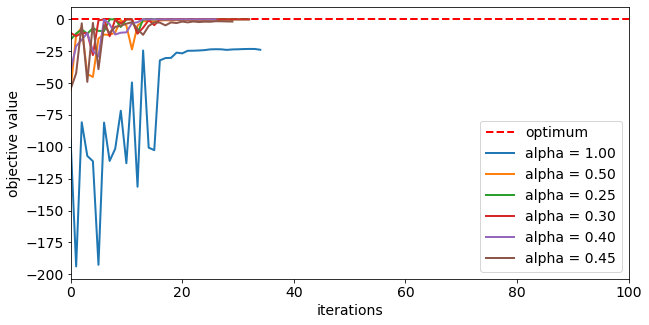

In [30]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [31]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 207), ('u', 111)])

In [32]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 941.05
Total cost for when alpha is 0.5: 806.65
Total cost for when alpha is 0.25: 887.29
Total cost for when alpha is 0.3: 887.29
Total cost for when alpha is 0.4: 726.01
Total cost for when alpha is 0.45: 806.65


In [33]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.25355531011501853
The optimal value with alpha 0.5: -0.25355531011501853
The optimal value with alpha 0.25: -0.25355531011501853
The optimal value with alpha 0.3: -0.25355531011501853
The optimal value with alpha 0.4: -0.25355531011501853
The optimal value with alpha 0.45: -0.25355531011501853


In [34]:
### Circuit depth ###

qc_basis.depth()

147

In [35]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 111.28699827194214
Optimizer time for alpha 0.5: 95.66699504852295
Optimizer time for alpha 0.25: 102.94009137153625
Optimizer time for alpha 0.3: 101.21307015419006
Optimizer time for alpha 0.4: 86.69768857955933
Optimizer time for alpha 0.45: 96.76262307167053


Note:alpha=0.4 seems best due to slightly lower cost and the same optimal value as alpha 1, alpha 0.25,alpha 0.30,alpha 0.50,alpha 0.45. This is because alpha=0.5 led to convergence much faster.

3-FakeToronto device backend

In [36]:
import os
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeToronto
from qiskit.utils import QuantumInstance

device_backend = FakeToronto()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['cx', 'reset', 'sx', 'id', 'x', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [37]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.25355531011501853
variable values: x_0=1.

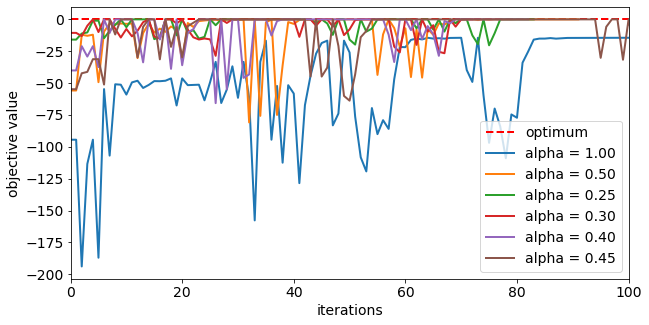

In [103]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [40]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 254), ('u', 99)])

In [104]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 4641.2228000000005
Total cost for when alpha is 0.5: 2482.6308000000004
Total cost for when alpha is 0.25: 2266.7716
Total cost for when alpha is 0.3: 1969.9652
Total cost for when alpha is 0.4: 2239.7892
Total cost for when alpha is 0.45: 4371.3988


In [105]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.25355531011501853
The optimal value with alpha 0.5: -0.25355531011501853
The optimal value with alpha 0.25: -0.25355531011501853
The optimal value with alpha 0.3: -0.25355531011501853
The optimal value with alpha 0.4: -0.25355531011501853
The optimal value with alpha 0.45: -0.25355531011501853


Note:alpha=0.3 seems best due to slightly lower cost and the same optimal value as alpha 1, alpha 0.25,alpha 0.40,alpha 0.50,alpha 0.45. This is because alpha=0.3 led to convergence much faster.

Using 'CG' optimizer and qasm simulator. We are using CVaR expectation and hence, created a list of alpha values

In [43]:
# set classical optimizer
maxiter = 100
optimizer = CG(maxiter=maxiter)

# set variational ansatz
#ansatz = RealAmplitudes(n, reps=1)
#m = ansatz.num_parameters

# set backend
backend_name = "qasm_simulator"  # use this for QASM simulator
# backend_name = 'aer_simulator_statevector'  # use this for statevector simlator
backend = Aer.get_backend(backend_name)

# run variational optimization for different values of alpha
alphas = [1.0, 0.50, 0.25,0.30,0.40,0.45]  # confidence levels to be evaluated

Fitting CVaR QAOA

In [44]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=backend,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.2544783085699578
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=1.0, x_4=0.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.5:
objective function value: -20.169527317724942
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.26203586675501356
variable values: x_0=0.0, x_1=1.0, x_2=1.0, x_3=1.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=0.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.2545840656400742
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0, x_8=0.0, x_9=1.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.25355531011501853
variable values: x_0=1.0, 

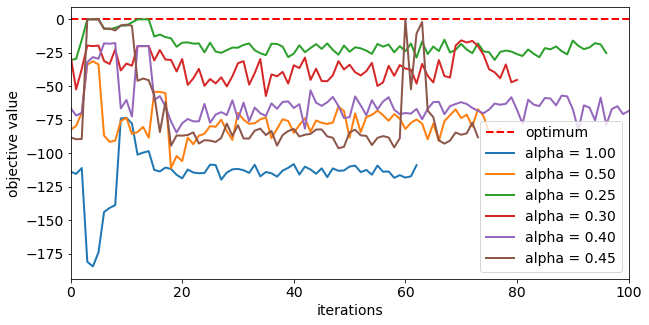

In [45]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [46]:
qaoa.ansatz.count_ops()

OrderedDict([('h', 10), ('PauliEvolution', 2)])

In [47]:
from qiskit import transpile

In [48]:
qc_basis = transpile(qaoa.ansatz, backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

In [49]:
gate_dict

OrderedDict([('cx', 90), ('u', 75)])

Finding the circuit cost

In [50]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 822.778
Total cost for when alpha is 0.5: 1018.618
Total cost for when alpha is 0.25: 1266.682
Total cost for when alpha is 0.3: 1057.786
Total cost for when alpha is 0.4: 1397.2420000000002
Total cost for when alpha is 0.45: 966.3940000000001


We evaluated the cost for different alphas, but we also need to see if we are not too far away from optimal even if the cost is least for any alpha. Based on that, we could conclude which alpha works best. We can see this from the plot itself and also from the cell output where we ran QAOA, but lets print the exact optimal value here.

In [51]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.2544783085699578
The optimal value with alpha 0.5: -20.169527317724942
The optimal value with alpha 0.25: -0.25355531011501853
The optimal value with alpha 0.3: -0.26203586675501356
The optimal value with alpha 0.4: -0.2545840656400742
The optimal value with alpha 0.45: -0.25355531011501853


alpha=1 seems best due to slightly lower cost and almost the same optimal value as alpha 0.5,alpha 0.25,alpha 0.3,alpha 0.4,alpha 0.45.This is because alpha=1 led to convergence much faster.

Circuit depth

In [52]:
qc_basis.depth()

54

Optimizer time



In [53]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 144.0208888053894
Optimizer time for alpha 0.5: 103.16235613822937
Optimizer time for alpha 0.25: 142.52650833129883
Optimizer time for alpha 0.3: 87.39477324485779
Optimizer time for alpha 0.4: 121.144033908844
Optimizer time for alpha 0.45: 90.00630354881287


Trying different fake backends and using noise models for the same experiment

The fake backends are built to mimic the behaviors of IBM Quantum systems using system snapshots. The system snapshots contain important information about the quantum system such as coupling map, basis gates, qubit properties (T1, T2, error rate, etc.) which are useful for testing the transpiler and performing noisy simulation of the system.

1- FakeMumbai backend

In [54]:
import os
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeSydney, FakeMumbai
from qiskit.utils import QuantumInstance

In [55]:
device_backend = FakeMumbai()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['cx', 'reset', 'sx', 'id', 'x', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [56]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.2553761834199122
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=0.0, x_9=1.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.2544783085699578
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=1.0, x_4=0.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.2544783085699578
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=1.0, x_4=0.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.2545840656400742
variable values: x_0=1.0, x

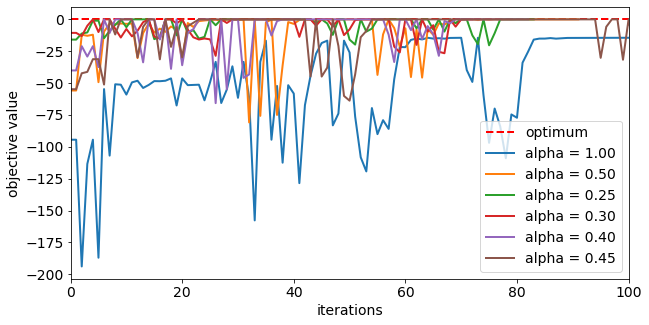

In [98]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [99]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 208), ('u', 111)])

In [106]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 4641.2228000000005
Total cost for when alpha is 0.5: 2482.6308000000004
Total cost for when alpha is 0.25: 2266.7716
Total cost for when alpha is 0.3: 1969.9652
Total cost for when alpha is 0.4: 2239.7892
Total cost for when alpha is 0.45: 4371.3988


In [60]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.25355531011501853
The optimal value with alpha 0.5: -0.25355531011501853
The optimal value with alpha 0.25: -0.2553761834199122
The optimal value with alpha 0.3: -0.2544783085699578
The optimal value with alpha 0.4: -0.2544783085699578
The optimal value with alpha 0.45: -0.2545840656400742


In [61]:
### Circuit depth ###

qc_basis.depth()

173

In [62]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 10.46592116355896
Optimizer time for alpha 0.5: 44.077733278274536
Optimizer time for alpha 0.25: 7.778893947601318
Optimizer time for alpha 0.3: 9.526379108428955
Optimizer time for alpha 0.4: 7.928551912307739
Optimizer time for alpha 0.45: 7.343663692474365


3-FakeToronto device backend

In [63]:
import os
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeToronto
from qiskit.utils import QuantumInstance

device_backend = FakeToronto()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['cx', 'reset', 'sx', 'id', 'x', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [95]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.25355531011501853
variable values: x_0=1.

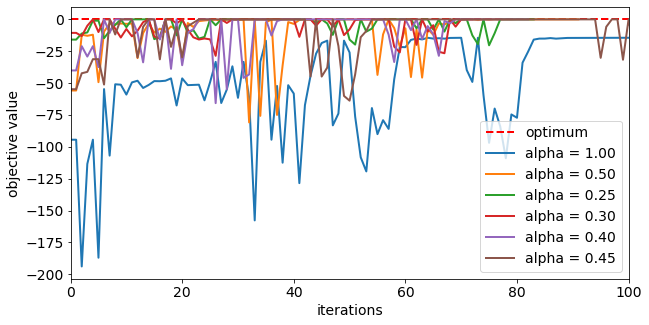

In [96]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [65]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 205), ('u', 105)])

In [101]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 4641.2228000000005
Total cost for when alpha is 0.5: 2482.6308000000004
Total cost for when alpha is 0.25: 2266.7716
Total cost for when alpha is 0.3: 1969.9652
Total cost for when alpha is 0.4: 2239.7892
Total cost for when alpha is 0.45: 4371.3988


In [102]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.25355531011501853
The optimal value with alpha 0.5: -0.25355531011501853
The optimal value with alpha 0.25: -0.25355531011501853
The optimal value with alpha 0.3: -0.25355531011501853
The optimal value with alpha 0.4: -0.25355531011501853
The optimal value with alpha 0.45: -0.25355531011501853


Note : For both the fake bckends,  alpha=0.3 seems best due to slightly lower cost and the same optimal value as alpha 0.5,alpha 0.25,alpha 1,alpha 0.4 ,alpha 0.45.This is because alpha=0.3 led to convergence much faster.

Using 'POWELL' optimizer and qasm simulator. We are using CVaR expectation and hence, created a list of alpha values

In [68]:
# set classical optimizer
maxiter = 100
optimizer = POWELL(maxiter=maxiter)

# set variational ansatz
#ansatz = RealAmplitudes(n, reps=1)
#m = ansatz.num_parameters

# set backend
backend_name = "qasm_simulator"  # use this for QASM simulator
# backend_name = 'aer_simulator_statevector'  # use this for statevector simlator
backend = Aer.get_backend(backend_name)

# run variational optimization for different values of alpha
alphas = [1.0, 0.50, 0.25,0.30,0.40,0.45]  # confidence levels to be evaluated

Fitting CVaR QAOA

In [69]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=backend,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.25355531011501853
variable values: x_0=1.

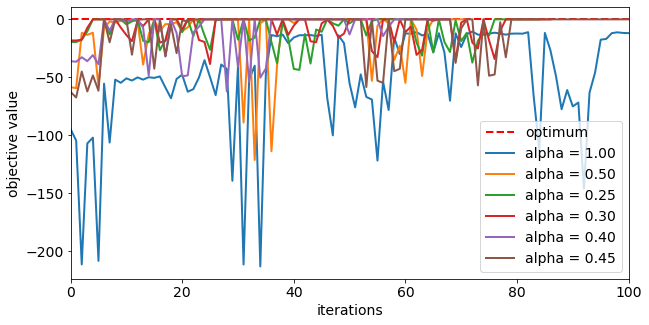

In [70]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [71]:
qaoa.ansatz.count_ops()

OrderedDict([('h', 10), ('PauliEvolution', 2)])

In [72]:
from qiskit import transpile

In [73]:
qc_basis = transpile(qaoa.ansatz, backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

In [74]:
gate_dict

OrderedDict([('cx', 90), ('u', 75)])

Finding the circuit cost



In [75]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 1580.026
Total cost for when alpha is 0.5: 940.282
Total cost for when alpha is 0.25: 1110.01
Total cost for when alpha is 0.3: 1136.122
Total cost for when alpha is 0.4: 901.114
Total cost for when alpha is 0.45: 1371.13


We evaluated the cost for different alphas, but we also need to see if we are not too far away from optimal even if the cost is least for any alpha. Based on that, we could conclude which alpha works best. We can see this from the plot itself and also from the cell output where we ran QAOA, but lets print the exact optimal value here.

In [76]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.25355531011501853
The optimal value with alpha 0.5: -0.25355531011501853
The optimal value with alpha 0.25: -0.25355531011501853
The optimal value with alpha 0.3: -0.25355531011501853
The optimal value with alpha 0.4: -0.25355531011501853
The optimal value with alpha 0.45: -0.25355531011501853


alpha=0.4 seems best due to slightly lower cost and the same optimal value as alpha 0.5,alpha 0.25,alpha 1,alpha0.3 ,alpha 0.45.This is because alpha=0.4 led to convergence much faster.

Circuit depth



In [77]:
qc_basis.depth()

54

Optimizer time

In [78]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 258.3634111881256
Optimizer time for alpha 0.5: 144.24836611747742
Optimizer time for alpha 0.25: 165.58020567893982
Optimizer time for alpha 0.3: 174.75629806518555
Optimizer time for alpha 0.4: 138.67088985443115
Optimizer time for alpha 0.45: 205.38403129577637


Trying different fake backends and using noise models for the same experiment

1- FakeMumbai backend

In [79]:
import os
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeSydney, FakeMumbai
from qiskit.utils import QuantumInstance

In [80]:
device_backend = FakeMumbai()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['cx', 'reset', 'sx', 'id', 'x', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [81]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.25355531011501853
variable values: x_0=1.

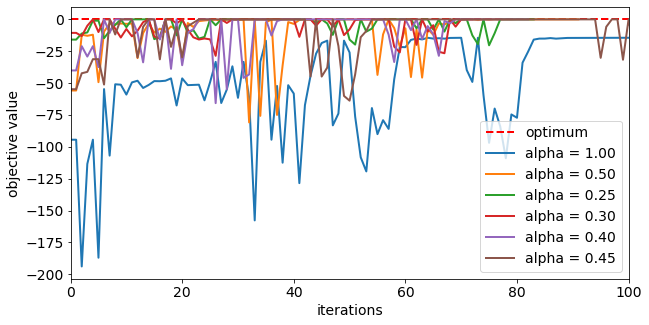

In [82]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [83]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 198), ('u', 111)])

In [97]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 4958.2532
Total cost for when alpha is 0.5: 2652.2052000000003
Total cost for when alpha is 0.25: 2421.6004000000003
Total cost for when alpha is 0.3: 2104.5188000000003
Total cost for when alpha is 0.4: 2392.7748
Total cost for when alpha is 0.45: 4669.9972


In [85]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.25355531011501853
The optimal value with alpha 0.5: -0.25355531011501853
The optimal value with alpha 0.25: -0.25355531011501853
The optimal value with alpha 0.3: -0.25355531011501853
The optimal value with alpha 0.4: -0.25355531011501853
The optimal value with alpha 0.45: -0.25355531011501853


In [86]:
### Circuit depth ###

qc_basis.depth()

161

In [87]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 501.1432116031647
Optimizer time for alpha 0.5: 260.1189820766449
Optimizer time for alpha 0.25: 243.45147275924683
Optimizer time for alpha 0.3: 216.77837324142456
Optimizer time for alpha 0.4: 237.9919548034668
Optimizer time for alpha 0.45: 465.56928539276123


3-FakeToronto device backend

In [88]:
import os
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeToronto
from qiskit.utils import QuantumInstance

device_backend = FakeToronto()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['cx', 'reset', 'sx', 'id', 'x', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [89]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.25355531011501853
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.2538738783798635
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=0.0, x_6=1.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.25355531011501853
variable values: x_0=1.0

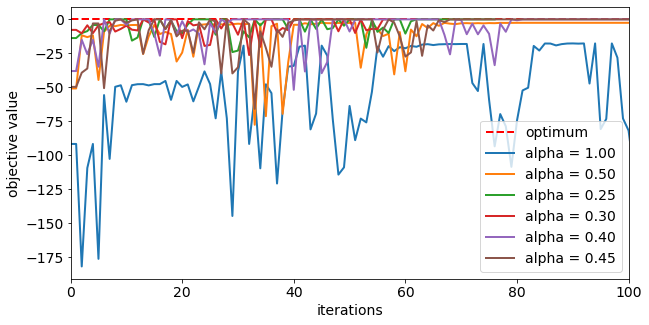

In [90]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [91]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 208), ('u', 147)])

In [92]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 6514.8356
Total cost for when alpha is 0.5: 5880.6724
Total cost for when alpha is 0.25: 2219.8212000000003
Total cost for when alpha is 0.3: 1700.9604000000002
Total cost for when alpha is 0.4: 2969.2868000000003
Total cost for when alpha is 0.45: 4122.3108


In [93]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.25355531011501853
The optimal value with alpha 0.5: -0.25355531011501853
The optimal value with alpha 0.25: -0.25355531011501853
The optimal value with alpha 0.3: -0.25355531011501853
The optimal value with alpha 0.4: -0.2538738783798635
The optimal value with alpha 0.45: -0.25355531011501853


Note:For both the fake backends, alpha=0.3 seems best due to slightly lower cost and the same optimal value as alpha 0.5,alpha 0.25,alpha 1,alpha 0.4 ,alpha 0.45.This is because alpha=0.3 led to convergence much faster.

### Conclusion : 1) As we concluded from our results running on IBM quantum cloud that Fake Backend Washington was a poor choice where it has large no of Qubits i.e.127 which is not require for our used cases.
###  2)Secondaly on IBM Quantum Cloud, Fake Mumbai And Fake Torronto backend was taking time approximately ~ 1 hour to print the required result but running it locally is taking comparatively less time.
### 3) For a particular case of Optimisers it is showing different alpha's cost when trying it on qasm simulator and different fake backends
 Reason might be the error parameters and noise is a little more 